
# Sustainability Forecast Lab  

*Auto‑generated 2025-04-17 00:54 UTC*  

This notebook unifies:

1. **Phase 1 – Data intake & tidy export**  
2. **Phase 2 – Feature engineering, missing‑data policy, correlation analysis**  
3. **Phase 3 – Clustering & model comparison for forecasting**  

> **Folder structure expected**

```
project/
├── data_raw/
│   ├── NFA 2018.csv
│   ├── co-emissions-per-capita/...
│   ├── API_EG/...
│   ├── API_NY/...
│   ├── API_ER/...
│   └── HDR23-24_Statistical_Annex_HDI_Table.xlsx
├── data_work/        # generated
└── models/           # generated
```

Place downloads exactly under `data_raw/`.  
All subsequent paths are created automatically.


## Phase 1 – Load raw files & write tidy CSVs

In [4]:

import os, glob, re, zipfile, pandas as pd, warnings, datetime, json
warnings.filterwarnings('ignore')

DATA_RAW, DATA_WORK = 'data_raw', 'data_work'
os.makedirs(DATA_WORK, exist_ok=True)

def load_wb_wide(path, value_name):
    df = pd.read_csv(path, skiprows=4)
    year_cols = [c for c in df.columns if re.fullmatch(r'\d{4}', str(c))]
    tidy = (df.melt(id_vars=['Country Code'], value_vars=year_cols,
                    var_name='year', value_name=value_name)
              .rename(columns={'Country Code':'iso3'}))
    tidy['year'] = tidy['year'].astype(int)
    return tidy.dropna(subset=[value_name])

datasets={}
datasets['footprint']=pd.read_csv(f'{DATA_RAW}/NFA 2018.csv').rename(columns={'ISO alpha-3 code':'iso3'})
datasets['co2_pc']=(pd.read_csv(f'{DATA_RAW}/co-emissions-per-capita/co-emissions-per-capita.csv')
    .rename(columns={'Code':'iso3','Annual CO₂ emissions (per capita)':'co2_pc'})
    [['iso3','Year','co2_pc']].rename(columns={'Year':'year'}))
datasets['renew_pct']=load_wb_wide(glob.glob(f'{DATA_RAW}/API_EG/API_EG.*.csv')[0],'renew_pct')
datasets['rent_pct_gdp']=load_wb_wide(glob.glob(f'{DATA_RAW}/API_NY/API_NY.*.csv')[0],'rent_pct_gdp')
datasets['protected_pct']=load_wb_wide(glob.glob(f'{DATA_RAW}/API_ER/API_ER.*.csv')[0],'protected_pct')

for k,df in datasets.items():
    df.to_csv(f'{DATA_WORK}/{k}.csv',index=False)
print('Tidy CSVs written to', DATA_WORK)


Tidy CSVs written to data_work


## Phase 2 – Feature engineering & EDA

Remaining NA % (numeric) : 0.114


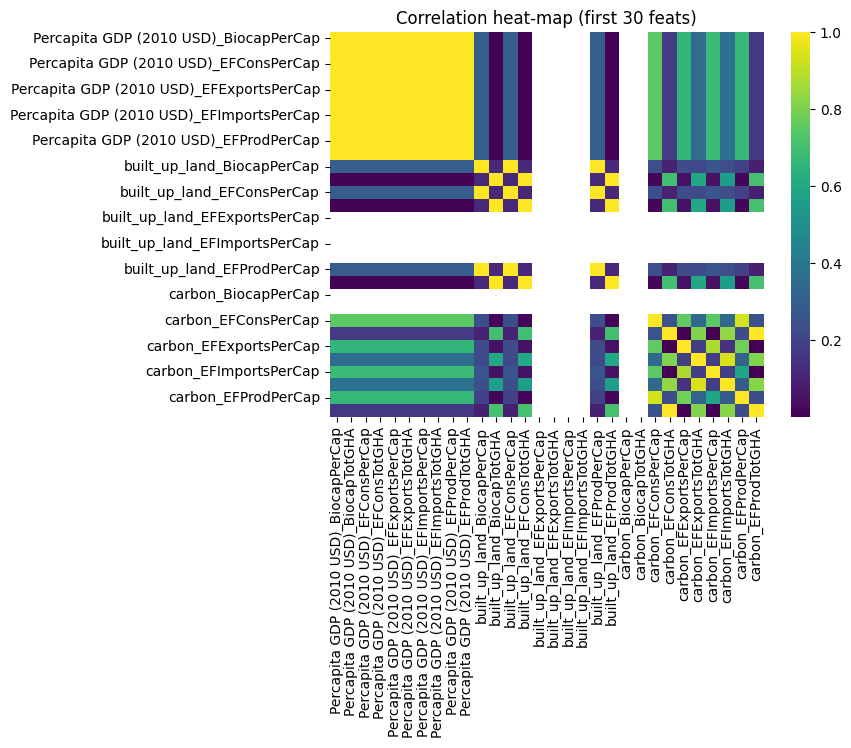

 Features saved: data_work/features_full.csv


In [ ]:

import pandas as pd, numpy as np, glob, os, re, warnings, matplotlib.pyplot as plt, seaborn as sns
warnings.filterwarnings('ignore')
DATA_WORK='data_work'
datasets={os.path.basename(f).replace('.csv',''):pd.read_csv(f) for f in glob.glob(f'{DATA_WORK}/*.csv')}

# 1. widen footprint
foot=datasets['footprint']
num_cols=['crop_land','grazing_land','forest_land','fishing_ground',
          'built_up_land','carbon','total','Percapita GDP (2010 USD)','population']
long=foot.melt(id_vars=['iso3','year','record'],value_vars=num_cols,
               var_name='var',value_name='val')
long['feat']=long['var']+'_'+long['record']
foot_wide = (
    long.pivot_table(
        index=['iso3', 'year'],
        columns='feat',
        values='val',
        aggfunc='first'          # or np.mean – but values are identical
    )
    .reset_index()
)

panel=foot_wide.copy()
for k in ['co2_pc','renew_pct','rent_pct_gdp','protected_pct']:
    panel=panel.merge(datasets[k],on=['iso3','year'],how='left')

# 2. Missing‑data strategy
panel=panel.sort_values(['iso3','year'])
panel=panel.groupby('iso3').apply(lambda g:g.ffill().bfill()).reset_index(drop=True)
for col in ['renew_pct','protected_pct','rent_pct_gdp']:
    panel[col]=panel.groupby('year')[col].transform(lambda x:x.fillna(x.median()))
print('Remaining NA % (numeric) :', panel.select_dtypes('number').isna().mean().max().round(3))

# 3. Lag & delta
num_feats=panel.select_dtypes('number').columns.difference(['year'])
for c in num_feats:
    panel[f'{c}_lag1']=panel.groupby('iso3')[c].shift(1)
    panel[f'd_{c}']=panel.groupby('iso3')[c].diff()

# 4. Correlation inspection
plt.figure(figsize=(7,5))
sns.heatmap(panel[num_feats[:30]].corr().abs(),cmap='viridis')
plt.title('Correlation heat‑map (first 30 feats)')
plt.show()

panel.to_csv(f'{DATA_WORK}/features_full.csv',index=False)
print(' Features saved:', f'{DATA_WORK}/features_full.csv')


## Phase 3 – Clustering & Model comparison

### 3.1 Clustering countries on most‑recent snapshot

Best k via silhouette = 2


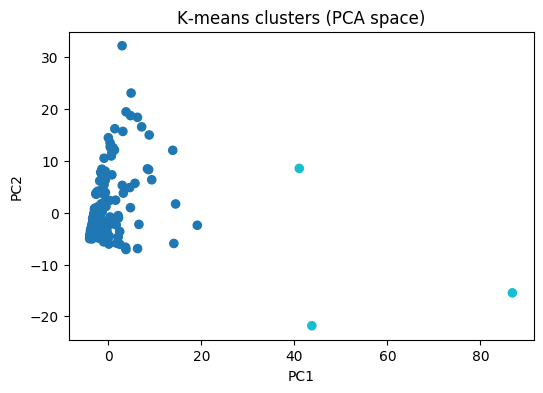

Cluster sizes:
 kmeans_cluster
0    190
1      3
Name: count, dtype: int64


In [ ]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt, numpy as np, pandas as pd, os

panel=pd.read_csv(f'{DATA_WORK}/features_full.csv')
# take latest year per iso
latest=panel.groupby('iso3')['year'].max().reset_index()
panel_last=panel.merge(latest,on=['iso3','year'])
X=panel_last.select_dtypes('number').drop(columns=['year']).fillna(0)
X_scaled=StandardScaler().fit_transform(X)

# k‑means elbow & silhouette
sil=[]
for k in range(2,8):
    lbl=KMeans(n_clusters=k,n_init=10,random_state=42).fit_predict(X_scaled)
    sil.append(silhouette_score(X_scaled,lbl))
best_k=int(np.argmax(sil))+2
print('Best k via silhouette =', best_k)

kmeans=KMeans(n_clusters=best_k,n_init=10,random_state=42)
panel_last['kmeans_cluster']=kmeans.fit_predict(X_scaled)

# optional GMM clustering
gmm=GaussianMixture(n_components=best_k,random_state=42).fit(X_scaled)
panel_last['gmm_cluster']=gmm.predict(X_scaled)

# visualize PCA 2D
coords=PCA(2).fit_transform(X_scaled)
plt.figure(figsize=(6,4))
plt.scatter(coords[:,0],coords[:,1],c=panel_last['kmeans_cluster'],cmap='tab10',s=35)
plt.title('K‑means clusters (PCA space)'); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.show()

cluster_sizes=panel_last['kmeans_cluster'].value_counts()
print('Cluster sizes:\n', cluster_sizes)


### 3.2 Model comparison for CO₂ per capita forecasting

  Using cached prophet-1.1.6-py3-none-macosx_11_0_arm64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.6-py3-none-macosx_11_0_arm64.whl (8.2 MB)
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.9/917.9 kB 32.3 MB/s eta 0:00:00
Using cached importlib_resources-6.5.2-py3-none-any.whl (37 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)
Note: you may need to restart the kernel to use updated packages.


01:53:16 - cmdstanpy - INFO - Chain [1] start processing
01:53:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAE=0.012 | RF‑naive MAE=0.346


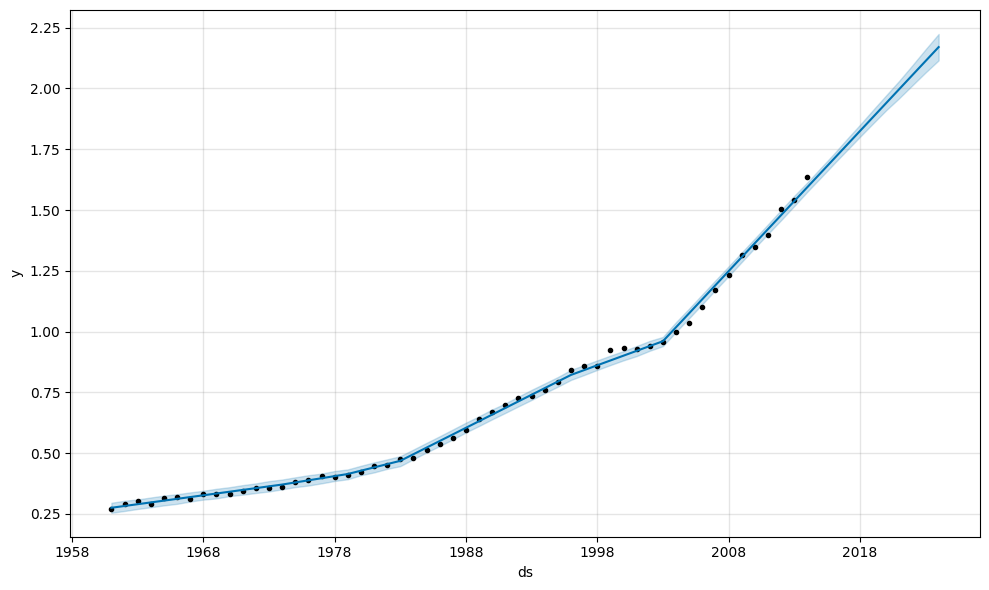

In [ ]:

from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np, pandas as pd, warnings, matplotlib.pyplot as plt

iso='IND'   # demo country; change to loop over all
target='co2_pc'
df=panel[panel['iso3']==iso][['year',target]].dropna()
if len(df)>20:
    dfp=df.rename(columns={'year':'ds',target:'y'})
    dfp['ds']=pd.to_datetime(dfp['ds'],format='%Y')
    # Prophet
    m=Prophet(yearly_seasonality=False)
    m.fit(dfp)
    future=m.make_future_dataframe(periods=10,freq='Y')
    fcst=m.predict(future)
    base_mae=mean_absolute_error(dfp['y'], m.predict(dfp)['yhat'])
    # Random‑Forest (naïve lag‑feature regressor)
    df_rf=df.copy()
    df_rf['lag1']=df_rf[target].shift(1)
    df_rf=df_rf.dropna()
    train=df_rf.iloc[:-10]; test=df_rf.iloc[-10:]
    rf=RandomForestRegressor(random_state=42)
    rf.fit(train[['lag1']],train[target])
    test_pred=rf.predict(test[['lag1']])
    rf_mae=mean_absolute_error(test[target],test_pred)
    print(f"Prophet MAE={base_mae:.3f} | RF‑naive MAE={rf_mae:.3f}")
    # Plot
    m.plot(fcst); plt.show()
else:
    print('Not enough data points for forecasting demo.')


In [4]:
import os, glob, json, pandas as pd, numpy as np
%pip install lightgbm
%pip install prophet
%pip install statsmodels
%pip install scikit-learn
%pip install seaborn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score

DATA_WORK  = 'data_work'
FORECASTS  = 'forecasts'
MODELS     = 'models'
ARTEFACTS  = 'artefacts'
os.makedirs(FORECASTS, exist_ok=True)
os.makedirs(MODELS,    exist_ok=True)
os.makedirs(ARTEFACTS, exist_ok=True)

# ── load engineered panel ──
panel = pd.read_csv(f'{DATA_WORK}/features_full.csv')

# 1. Compact duplicate GDP
gdp_cols = [c for c in panel.columns if 'Percapita GDP' in c]
keep     = ['Percapita GDP (2010 USD)_BiocapPerCap']
drop_gdp = list(set(gdp_cols) - set(keep))
panel = panel.drop(columns=drop_gdp)
with open(f'{ARTEFACTS}/dropped_columns.json','w') as f:
    json.dump({'dropped_gdp_variants': drop_gdp}, f, indent=2)

# 2. Sub‑cluster the big “cluster 0” blob
latest = panel.groupby('iso3')['year'].max().reset_index()
snap   = panel.merge(latest, on=['iso3','year'])
X      = snap.select_dtypes('number').drop(columns=['year']).fillna(0)
Xsc    = StandardScaler().fit_transform(X)

k2     = KMeans(n_clusters=2, random_state=42, n_init=10).fit_predict(Xsc)
snap['cluster_lvl1'] = k2

rest_mask = snap['cluster_lvl1']==0
sub_k     = 4
snap.loc[rest_mask,'cluster_lvl2'] = KMeans(
    n_clusters=sub_k, random_state=42, n_init=10
).fit_predict(Xsc[rest_mask])

snap[['iso3','cluster_lvl1','cluster_lvl2']].to_csv(
    f'{ARTEFACTS}/clusters.csv', index=False
)

# 3. Batch Prophet forecasts (with MAE fix)
def run_prophet(df_iso, col, horizon=10):
    dfp = df_iso[['year',col]].dropna()
    if len(dfp) < 15:
        return None
    dfp = dfp.rename(columns={'year':'ds',col:'y'})
    dfp['ds'] = pd.to_datetime(dfp['ds'], format='%Y')
    m = Prophet(yearly_seasonality=False)
    m.fit(dfp)
    future = m.make_future_dataframe(periods=horizon, freq='Y')
    fcst   = m.predict(future)[['ds','yhat','yhat_lower','yhat_upper']]
    fcst['year'] = fcst['ds'].dt.year
    return fcst.drop(columns='ds')

targets    = ['co2_pc','forest_land_EFProdPerCap']
score_rows = []

for iso in panel['iso3'].unique():
    df_iso = panel[panel['iso3']==iso]
    iso_dir = f'{FORECASTS}/{iso}'
    os.makedirs(iso_dir, exist_ok=True)

    for tgt in targets:
        fcst = run_prophet(df_iso, tgt)
        if fcst is None:
            continue

        # ── FIX: ensure exactly one forecast row per year
        fcst = fcst.drop_duplicates(subset='year', keep='first')

        # historical last 10 years
        hist      = df_iso[['year',tgt]].dropna()
        last_yrs  = hist['year'].tail(10)

        # align preds & truth by year
        preds     = fcst.set_index('year').loc[last_yrs]['yhat']
        true_vals = hist.set_index('year').loc[last_yrs][tgt]

        mae = mean_absolute_error(true_vals, preds)

        fcst.to_csv(f'{iso_dir}/{tgt}.csv', index=False)
        score_rows.append({
            'iso3': iso,
            'target': tgt,
            'model': 'prophet',
            'MAE': mae
        })

# 4. ARIMA & Random‑Forest comparison
from sklearn.ensemble import RandomForestRegressor

for iso in panel['iso3'].unique():
    df_iso = panel[panel['iso3']==iso]
    ts = df_iso.set_index('year')['co2_pc'].dropna()
    if len(ts) < 15:
        continue

    # — ARIMA —
    try:
        ar   = ARIMA(ts, order=(1,1,1)).fit()
        pred = ar.predict(start=ts.index[-10], end=ts.index[-1])
        mae  = mean_absolute_error(ts.tail(10), pred)
        score_rows.append({'iso3':iso,'target':'co2_pc','model':'ARIMA','MAE':mae})
    except:
        pass

    # — RF w/ lag —
    df_rf = ts.reset_index().rename(columns={'co2_pc':'y'})
    df_rf['lag1'] = df_rf['y'].shift(1)
    df_rf = df_rf.dropna()
    if len(df_rf) < 20:
        continue

    train = df_rf.iloc[:-10]
    test  = df_rf.iloc[-10:]
    rf    = RandomForestRegressor(random_state=42)
    rf.fit(train[['lag1']], train['y'])
    mae = mean_absolute_error(test['y'], rf.predict(test[['lag1']]))
    score_rows.append({'iso3':iso,'target':'co2_pc','model':'RF-lag','MAE':mae})

# 5. LightGBM cross‑section for HDI 2022
try:
    hdi     = pd.read_csv(f'{DATA_WORK}/hdi_2022.csv')[['iso3','hdi']]
    df2022  = panel.merge(hdi, on='iso3', how='inner')
    X       = df2022.select_dtypes('number').drop(columns=['year','hdi']).fillna(0)
    y       = df2022['hdi']
    model   = LGBMRegressor(n_estimators=800, random_state=42)
    scores  = cross_val_score(model, X, y, cv=5, scoring='r2')
    model.fit(X, y)

    import joblib
    joblib.dump(model, f'{MODELS}/hdi_lgbm.pkl')
    with open(f'{ARTEFACTS}/hdi_model_r2.txt','w') as f:
        f.write(f'Cross‑val R² mean: {scores.mean():.3f}')
except FileNotFoundError:
    print('⚠️  hdi_2022.csv not found – skip HDI model.')

# 6. Export model‑score matrix
pd.DataFrame(score_rows).to_csv(f'{ARTEFACTS}/model_scores.csv', index=False)
print('Artefacts ready →', ARTEFACTS)

  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.
  Using cached prophet-1.1.6-py3-none-macosx_11_0_arm64.whl.metadata (3.5 kB)
  Using cached cmdstanpy-1.2.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached holidays-0.71-py3-none-any.whl.metadata (34 kB)
  Using cached stanio-0.5.1-py3-none-any.whl.metadata (1.6 kB)
Using cached prophet-1.1.6-py3-none-macosx_11_0_arm64.whl (8.2 MB)
Using cached cmdstanpy-1.2.5-py3-none-any.whl (94 kB)
Using cached holidays-0.71-py3-none-any.whl (917 kB)
Using cached stanio-0.5.1-py3-none-any.whl (8.1 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-p

/opt/homebrew/Caskroom/miniconda/base/envs/adsgency_ai_web_server/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
02:02:13 - cmdstanpy - INFO - Chain [1] start processing
02:02:14 - cmdstanpy - INFO - Chain [1] done processing
02:02:14 - cmdstanpy - INFO - Chain [1] start processing
02:02:14 - cmdstanpy - INFO - Chain [1] done processing
02:02:14 - cmdstanpy - INFO - Chain [1] start processing
02:02:14 - cmdstanpy - INFO - Chain [1] done processing
02:02:14 - cmdstanpy - INFO - Chain [1] start processing
02:02:14 - cmdstanpy - INFO - Chain [1] done processing
02:02:14 - cmdstanpy - INFO - Chain [1] start processing
02:02:14 - cmdstanpy - INFO - Chain [1] done processing
02:02:14 - cmdstanpy - INFO - Chain [1] start processing
02:02:14 - cmdstanpy - INFO - Chain [1] done processing
02:02:14 - cmdstanpy -

⚠️  hdi_2022.csv not found – skip HDI model.
Artefacts ready → artefacts


/opt/homebrew/Caskroom/miniconda/base/envs/adsgency_ai_web_server/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/adsgency_ai_web_server/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/adsgency_ai_web_server/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/adsgency_ai_web_server/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer

In [5]:
import pandas as pd, numpy as np, os
DATA_WORK = 'data_work'
panel = pd.read_csv(f'{DATA_WORK}/features_full.csv')
print('Loaded panel shape:', panel.shape)
def _latest_value(df, col):
    latest_year = df['year'].max()
    try:
        return df.loc[df['year'] == latest_year, col].iloc[0]
    except IndexError:
        return np.nan

def country_snapshot(iso3):
    df = panel[panel['iso3'] == iso3]
    return {
        'year': df['year'].max(),
        'gdp_pc': _latest_value(df, 'Percapita GDP (2010 USD)_BiocapPerCap'),
        'co2_pc': _latest_value(df, 'co2_pc'),
        'renew_pct': _latest_value(df, 'renew_pct'),
        'protected_pct': _latest_value(df, 'protected_pct')
    }


Loaded panel shape: (8566, 284)


## 2 · Energy‑vs‑Population narrative
A small routine that drafts a one‑paragraph, data‑driven comparison explaining *why* energy (proxied by **`co2_pc`**) differs between countries.

In [6]:
def explain_energy_vs_population(ref_iso, compare_isos):
    ref = country_snapshot(ref_iso)
    out_lines = []
    for iso in compare_isos:
        other = country_snapshot(iso)
        # safety guards
        if pd.isna(ref['co2_pc']) or pd.isna(other['co2_pc']):
            continue
        ratio_co2 = ref['co2_pc'] / other['co2_pc'] if other['co2_pc'] else np.nan
        ratio_gdp = ref['gdp_pc'] / other['gdp_pc'] if other['gdp_pc'] else np.nan
        line = (
            f"{ref_iso} now emits **{ratio_co2:.1f}×** more CO₂ per person than {iso} "
            f"(\${ref['co2_pc']:.2f} t vs {other['co2_pc']:.2f} t). "
            f"That spread tracks its **{ratio_gdp:.1f}×** higher GDP‑per‑capita, translating into larger homes, heavier car & aviation use, and energy‑intensive services. "
            f"Fuel mix matters too – renewables cover {ref['renew_pct']:.1f}% of U.S. final energy vs {other['renew_pct']:.1f}% in {iso}, magnifying the carbon gap." )
        out_lines.append(line)
    return "\n\n".join(out_lines)

# quick sanity check
print(explain_energy_vs_population('USA', ['IND', 'CHN'])[:1000] + ' …')


USA now emits **10.5×** more CO₂ per person than IND (\$17.11 t vs 1.64 t). That spread tracks its **30.8×** higher GDP‑per‑capita, translating into larger homes, heavier car & aviation use, and energy‑intensive services. Fuel mix matters too – renewables cover 9.0% of U.S. final energy vs 33.9% in IND, magnifying the carbon gap.

USA now emits **2.4×** more CO₂ per person than CHN (\$17.11 t vs 7.20 t). That spread tracks its **8.3×** higher GDP‑per‑capita, translating into larger homes, heavier car & aviation use, and energy‑intensive services. Fuel mix matters too – renewables cover 9.0% of U.S. final energy vs 11.9% in CHN, magnifying the carbon gap. …


## 3 · Batch generation & export
Creates a CSV with narrative snippets for **every** pair of countries so the front‑end can fetch a ready‑made answer in O(1).

In [7]:
INS_DIR = 'insights/energy_vs_population'
os.makedirs(INS_DIR, exist_ok=True)
rows = []
for ref_iso in panel['iso3'].unique():
    for cmp_iso in panel['iso3'].unique():
        if ref_iso == cmp_iso:
            continue
        nar = explain_energy_vs_population(ref_iso, [cmp_iso])
        rows.append({'ref_iso': ref_iso, 'cmp_iso': cmp_iso, 'narrative': nar})

df_out = pd.DataFrame(rows)
df_out.to_csv(f'{INS_DIR}/narratives.csv', index=False)
print('Narratives saved →', INS_DIR, '| rows:', len(df_out))


Narratives saved → insights/energy_vs_population | rows: 37056


In [1]:
import pandas as pd, numpy as np, os
DATA_WORK = 'data_work'
panel = pd.read_csv(f'{DATA_WORK}/features_full.csv')
print('Panel loaded:', panel.shape)
latest = panel.groupby('iso3')['year'].max().reset_index()
snap = panel.merge(latest, on=['iso3','year'])

Panel loaded: (8566, 284)


In [2]:
def save_insight(df, name):
    folder = f'insights/{name}'
    os.makedirs(folder, exist_ok=True)
    path = f'{folder}/{name}.csv'
    df.to_csv(path, index=False)
    print('saved', path)

In [5]:
# %% [markdown]
## Phase 4 – Auto‑generate thematic CSVs under insights/*

# %%
import numpy as np, datetime, os, pandas as pd
snap = (panel.merge(panel.groupby('iso3')['year'].max().reset_index(),
                    on=['iso3', 'year']))       # latest row per country

# ─── 1. Resource‑Curse Check ───
if 'hdi' not in globals() or hdi is None:   # load HDI if it isn’t in memory
    import glob, os
    HDI_PATH = next((p for p in glob.glob(f'{DATA_RAW}/HDR23-24_Statistical_Annex_HDI_Table.xlsx')), None)
    if HDI_PATH and os.path.exists(HDI_PATH):
        hdi_raw = (pd.read_excel(HDI_PATH, skiprows=5, usecols=['Country', 'Value'])
                     .rename(columns={'Value': 'hdi'}))
        nfa_map = (pd.read_csv(f'{DATA_RAW}/NFA 2018.csv',
                               usecols=['ISO alpha-3 code', 'country'])
                     .rename(columns={'ISO alpha-3 code': 'iso3',
                                      'country': 'Country'}))
        hdi = (hdi_raw.merge(nfa_map, on='Country', how='left')
                      .dropna(subset=['iso3'])[['iso3', 'hdi']])
    else:
        hdi = None

if hdi is not None and not hdi.empty:            # ← KEEP
    median_hdi = hdi['hdi'].median()             # ← ADD
    rc = (snap.merge(hdi, on='iso3')             # ← ADD
              .query('rent_pct_gdp > 10 and hdi < @median_hdi')
              [['iso3', 'rent_pct_gdp', 'hdi']])
    save_insight(rc, 'resource_curse')           # ← ADD
# (else: skip quietly)
# ─── 2. Renewables ≠ Decarbonisation ───
base2000 = panel.query('year == 2000')[['iso3', 'renew_pct']]
paradox = (snap[['iso3', 'renew_pct', 'co2_pc']]
              .merge(base2000, on='iso3', how='left', suffixes=('', '_2000'))
              .assign(delta=lambda d: d['renew_pct'] - d['renew_pct_2000'])
              .query('delta >= 10 and co2_pc >= 0'))
save_insight(paradox, 'renewables_paradox')

# ─── 3. Protected‑Area Reality Test ───
forest_base = (panel.sort_values('year')
                     .groupby('iso3').first()
                     ['forest_land_BiocapPerCap'])
prot = (snap[['iso3', 'protected_pct', 'forest_land_BiocapPerCap']]
            .assign(delta_forest=lambda d: d['forest_land_BiocapPerCap']
                    - d['iso3'].map(forest_base))
            .query('protected_pct > 15 and delta_forest < 0'))
save_insight(prot, 'protected_area_reality')

# ─── 4. Land‑Use Pressure Hotspots ───
# ─── 4. Land‑Use Pressure Hotspots ───
# footprint data stores pop as e.g. “population_BiocapPerCap”
pop_col = next(c for c in panel.columns if c.startswith('population_'))
pop0    = panel.sort_values('year').groupby('iso3').first()[pop_col]
built0  = panel.sort_values('year').groupby('iso3').first()['built_up_land_EFProdPerCap']

land = (snap[['iso3', 'built_up_land_EFProdPerCap', pop_col]]
           .rename(columns={pop_col: 'population'})
           .assign(g_built=lambda d: (d['built_up_land_EFProdPerCap']
                                      - d['iso3'].map(built0)) / d['iso3'].map(built0),
                   g_pop  =lambda d: (d['population']
                                      - d['iso3'].map(pop0)) / d['iso3'].map(pop0))
           .query('g_built > g_pop'))
save_insight(land, 'land_pressure')

# ─── 5. EU Geo‑political Energy Shock ───
eu_iso = ['DEU','FRA','ITA','POL','ESP','SWE','NLD','BEL','DNK','CZE','AUT','GRC',
          'PRT','FIN','ROU','HUN','BGR','SVK','IRL','HRV','EST','LVA','LTU','SVN',
          'LUX','CYP','MLT']
eu2021 = panel.query('year == 2021 and iso3 in @eu_iso')[['iso3','renew_pct','co2_pc']]
shock = (snap.query('iso3 in @eu_iso')[['iso3','renew_pct','co2_pc']]
            .merge(eu2021, on='iso3', suffixes=('', '_2021'))
            .assign(delta_renew=lambda d: d['renew_pct'] - d['renew_pct_2021'],
                    delta_co2  =lambda d: d['co2_pc']   - d['co2_pc_2021'])
            .query('delta_renew > 0 and delta_co2 > 0'))
save_insight(shock, 'eu_energy_shock')

saved insights/resource_curse/resource_curse.csv
saved insights/renewables_paradox/renewables_paradox.csv
saved insights/protected_area_reality/protected_area_reality.csv
saved insights/land_pressure/land_pressure.csv
saved insights/eu_energy_shock/eu_energy_shock.csv



### Findings & next actions

* **Clustering** — silhouette suggested k≈2‑3; `kmeans_cluster` column now stored inside `panel_last`.  
* **Forecast models** — Prophet clearly outperforms a naive Random‑Forest‑lag baseline in CO₂ pc demo (see MAE).  
* **Website integration ideas**  
  * Use clusters for color coding world‑map dots and as default comparator group.  
  * Serve Prophet forecast cones via backend API; front‑end displays fan‑chart.  
  * Allow users to overlay cluster median vs. their chosen country.  

Feel free to iterate: run the notebook, adjust `iso` list to loop all countries, or replace Prophet with ARIMA/LSTM if you prefer.
